In [ ]:
# ! pip install timm
# ! git clone https://github.com/jaiwei98/MobileNetV4-pytorch mobilenet

In [ ]:
# Download the model of MobileNetV4 using git hub: 
# ! git clone https://github.com/jaiwei98/MobileNetV4-pytorch mobilenet


fatal: destination path 'mobilenet' already exists and is not an empty directory.


In [ ]:

# Run the Loader notebook
# %run "C:/Users/kagan/Dropbox/קורס DS בר-אילן/שיעורים/Projects/Final Project/Skin Cancer Detection/Src/Data_loader_1.ipynb"


In [2]:

import timm
import glob
import sys
import os
import warnings
from typing import Dict, Optional

import torchvision.models as models
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    auc
)

import pandas as pd
import numpy as np

from datetime import datetime
from PIL import Image

sys.path.append(os.path.join(os.getcwd(), "mobilenet")) # Add the mobilenet directory to the my path
from mobilenet.mobilenetv4 import MobileNetV4



import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader  # Add this import



In [7]:
sys.path.append(os.path.join(os.getcwd(), "mobilenet")) # Add the mobilenet directory to the my path
from mobilenet.mobilenetv4 import MobileNetV4


In [8]:
# Or Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mobilenet.mobilenetv4 import MobileNetV4

In [11]:
from mobilenet.mobilenetv4 import MobileNetV4


In [12]:
import os, sys
import mobilenet.mobilenetv4 as mm

# 1) What’s the current working directory?
print("Current working directory:", os.getcwd())

# 2) What paths is Python searching?
print("sys.path:")
for p in sys.path:
    print(" ", p)

# 3) Where did it actually load mobilenetv4.py from?
print("mobilenetv4 module file:", mm.__file__)

Current working directory: c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src
sys.path:
  C:\Users\kagan\anaconda3\python312.zip
  C:\Users\kagan\anaconda3\DLLs
  C:\Users\kagan\anaconda3\Lib
  C:\Users\kagan\anaconda3
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\venv
  
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\venv\Lib\site-packages
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\venv\Lib\site-packages\win32
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\venv\Lib\site-packages\win32\lib
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\venv\Lib\site-packages\Pythonwin
  c:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\mobilenet
  c:\Users\kagan\Dropbox\קורס DS

In [38]:
# Activate the virtual environment from bash:
.\venv\Scripts\Activate

SyntaxError: invalid syntax (4120898061.py, line 2)

In [6]:
# load the picke file from the previous notebook - loader.
combined_3 = pd.read_pickle(r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\combined_data.pkl")

In [39]:
import requests
import os

# URL of the MobileNetV4ConvMedium pre-trained weights on HuggingFace
weight_url = "https://huggingface.co/jaiwei98/MobileNetV4/resolve/main/MobileNetV4ConvMedium.pth"

# Path to save the downloaded weight file (in the Model_Weights directory)
model_weights_dir = r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights"
os.makedirs(model_weights_dir, exist_ok=True)  # ensure the directory exists
backbone_weights_path = os.path.join(model_weights_dir, "MobileNetV4ConvMedium.pth")

# Download the file if not already downloaded
if not os.path.isfile(backbone_weights_path):
    print(f"Downloading MobileNetV4ConvMedium weights to {backbone_weights_path} ...")
    response = requests.get(weight_url)
    response.raise_for_status()  # ensure the download was successful
    with open(backbone_weights_path, "wb") as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Pre-trained MobileNetV4ConvMedium weights already downloaded.")

Download complete!


In [10]:
nonlesion_dir = r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\not_lesion_images"
if not os.path.isdir(nonlesion_dir):
    raise FileNotFoundError(f"Non‐lesion folder not found: {nonlesion_dir}")

# Assume midas_data_1 is your filtered DataFrame and midas_image_dir is your image folder path
#  Define the folder containing MIDAS images
midas_image_dir = r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Midas_photos_data_2"
if not os.path.isdir(midas_image_dir):
    raise FileNotFoundError(f"Image directory not found: {midas_image_dir}")



In [59]:
 # Define the SkinLesionDataset Class
class SkinLesionDataset(Dataset):
    def __init__(self, df, midas_image_dir, nonlesion_dir, transform=None):
        """
        Arguments:
          - df              : Pandas DataFrame (combined_3) with columns:
                               ['midas_file_name','label','age_norm','gender_enc','is_from_non', …]
          - midas_image_dir : string path to the folder containing all MIDAS lesion images
          - nonlesion_dir   : string path to the folder containing all non‐lesion images
          - transform       : torchvision.transforms.Compose([...]) for resizing/normalizing images
                - 'midas_file_name' : filename of the image, e.g. 'ISIC_0001234.jpg'
          - 'label'           : integer 0/1/2/3
          - 'age_norm'        : float in [0.0, 1.0]
          - 'gender_enc'      : float (0.0 for male, 1.0 for female)
        
        FOLDERS:
      - midas_image_dir : path to folder containing lesion images
      - nonlesion_dir   : path to folder containing non-lesion images

        """
        super().__init__()
        # Work on a fresh copy of the DataFrame, reset index to ensure __getitem__ indexing is correct
        self.df = df.reset_index(drop=True)
        self.midas_image_dir = midas_image_dir
        self.nonlesion_dir   = nonlesion_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)# Return the number of samples

    def __getitem__(self, idx):
        """
        Returns exactly one sample (image_tensor, metadata_tensor, label_int).
        Called automatically by DataLoader when building batches.
        """
        row = self.df.iloc[idx]

        #  Decide and choose which folder the image lives in
        if row['is_from_non']:
            folder = self.nonlesion_dir
        else:
            folder = self.midas_image_dir

        #   Build the full image path and load the image
        img_path = os.path.join(folder, row['midas_file_name'])
        image = Image.open(img_path).convert('RGB')

        #  If a transform is provided, apply it here
        #  This should resize, normalize, and convert to FloatTensor
        # (will include augmentations during training)
        if self.transform is not None:
            image = self.transform(image) # # Now `image` is a FloatTensor of shape (3, 224, 224)
            

        #  Build the metadata tensor [age_norm, gender_enc]
        # # metadata: Tensor of shape (2,)
        metadata = torch.tensor([row['age_norm'], row['gender_enc']],
                                 dtype=torch.float32)

        #  Extract the integer label (0,1,2, or 3)
        label = int(row['label'])

        #  Return (image_tensor, metadata_tensor, label_int)
        return image, metadata, label


In [60]:
#  Define transforms with augmentations for training / simpler for val/test
#        Compose a transform that:
#       1) Resizes any image to 224×224
#       2) Converts PIL→Tensor (giving values in [0,1])
#       3) Normalizes per ImageNet statistics (zero mean, unit std)
import torchvision.transforms as transforms  # Add this import

#  Define the Image Transform (Resize + Normalize)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),        # Random crop + resize → 224×224
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(15),            # Random small rotation up to ±15°
    transforms.ColorJitter(brightness=0.2,    # Slight random color jitter
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.ToTensor(),                    # Convert PIL→Tensor ([0,1])
    transforms.Normalize(                     # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize to 224×224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [61]:
# Shuffle & split combined_3 into 70/15/15 splits
# ---------------------------------------------------

df = combined_3.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle the DataFrame
# Ensure reproducibility with random_state=42

n = len(df)
n_train = int(0.70 * n)
n_val   = int(0.15 * n)

train_df = df.iloc[0 : n_train].reset_index(drop=True)
val_df   = df.iloc[n_train : n_train + n_val].reset_index(drop=True)
test_df  = df.iloc[n_train + n_val : ].reset_index(drop=True)

print(f"Total rows: {n}")
print(f"Train rows: {len(train_df)}   Val rows: {len(val_df)}   Test rows: {len(test_df)}\n")



Total rows: 147965
Train rows: 103575   Val rows: 22194   Test rows: 22196



In [62]:
# Instantiate three Dataset objects (train / val / test),
#    now using TWO folders
# ---------------------------------------------------
train_ds = SkinLesionDataset(train_df, midas_image_dir, nonlesion_dir, train_transform)
val_ds   = SkinLesionDataset(val_df,   midas_image_dir, nonlesion_dir, val_transform)
test_ds  = SkinLesionDataset(test_df,  midas_image_dir, nonlesion_dir, val_transform)

print(f"Train dataset length: {len(train_ds)}")
print(f"Val   dataset length: {len(val_ds)}")
print(f"Test  dataset length: {len(test_ds)}\n")

Train dataset length: 103575
Val   dataset length: 22194
Test  dataset length: 22196



In [63]:

# Create DataLoaders for each split
# ---------------------------------------------------

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True    # shuffle during training
    # num_workers=4, pin_memory=True if using a GPU
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False   # no shuffle for validation
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False   # no shuffle for final evaluation
)

print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}\n")



Train batches: 3237
Val   batches: 694
Test  batches: 694



In [64]:

# Sanity‐check one batch from train_loader
imgs, metas, labs = next(iter(train_loader))
print("Batch images shape:   ", imgs.shape)   # expect (32, 3, 224, 224)
print("Batch metadata shape: ", metas.shape)  # expect (32, 2)
print("Batch labels shape:   ", labs.shape)   # expect (32,)

Batch images shape:    torch.Size([32, 3, 224, 224])
Batch metadata shape:  torch.Size([32, 2])
Batch labels shape:    torch.Size([32])


In [65]:
# fusion_model fixed 2: 

# Ensure that the path to mobilenetv4.py is accessible.
# If mobilenetv4.py is in a subfolder named 'mobilenet', make sure that folder
# has an __init__.py, and that fusion_model.py is alongside that folder.
#
# Example structure:
#   project_root/
#     fusion_model.py
#     mobilenet/
#       __init__.py
#       mobilenetv4.py

import os
import warnings
from typing import Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F

# Import your custom MobileNetV4 (no `pretrained` kwarg)
from mobilenet.mobilenetv4 import MobileNetV4  

class FusionModel(nn.Module):
    """
    FusionModel combines:
      • MobileNetV4-ConvMedium backbone (outputs a 1024-dim feature vector)
      • A metadata MLP that maps [age_norm, gender_enc] → 16-dim
      • A final classifier that maps (1024 + 16) → 4 class logits

    Classes:
      0 → Melanoma Detected
      1 → Other Skin Cancer Detected
      2 → Benign Lesion Detected
      3 → No Lesion Detected

    Features Added:
      - Option to load pretrained MobileNetV4 weights if provided
      - Input validation for image & metadata tensors
      - Expanded metadata MLP with BatchNorm & Dropout
      - Expanded classifier with additional layers, BatchNorm, Dropout
      - Confidence score / probability outputs in forward()
      - Weight initialization (He/kaiming) for non-pretrained parts
      - (Placeholder) gradient checkpointing flag for memory efficiency
    """

    def __init__(
        self,
        pretrained: bool = True,
        backbone_ckpt_path: Optional[str] = None
    ):
        super().__init__()

        # -------------------------------
        # 1) Instantiate the MobileNetV4-ConvMedium backbone
        # -------------------------------
        self.backbone = MobileNetV4("MobileNetV4ConvMedium")

        # -------------------------------
        # 1b) Load pretrained backbone weights if requested
        # -------------------------------
        if pretrained and backbone_ckpt_path is not None:
            if os.path.isfile(backbone_ckpt_path):
                try:
                    state = torch.load(backbone_ckpt_path, map_location="cpu")
                    self.backbone.load_state_dict(state, strict=False)
                    print(f"[FusionModel] Loaded pretrained backbone from '{backbone_ckpt_path}'.")
                except Exception as e:
                    warnings.warn(f"[FusionModel] Failed to load backbone checkpoint: {e}. Using random init.")
            else:
                warnings.warn(f"[FusionModel] Checkpoint '{backbone_ckpt_path}' not found. Using random init.")

        # -------------------------------
        # 2) Infer backbone output dimension via dummy forward
        # -------------------------------
        orig_mode = self.backbone.training
        self.backbone.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            feats = self.backbone(dummy)  # returns a list of feature maps
            # Final feature map has shape (1, 1024, 1, 1) → feature dim is 1024
            self.backbone_output_dim = feats[-1].shape[1]
        if orig_mode:
            self.backbone.train()

        # (Optional) enable gradient checkpointing for memory savings
        # self.backbone.use_checkpoint = True

        # -------------------------------
        # 3) Build metadata MLP: Input 2 → (64 → 32 → 16)
        # -------------------------------
        self.meta_net = nn.Sequential(
            nn.Linear(2,   64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64,  32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),

            nn.Linear(32,  16),
            nn.ReLU()
        )
        self.meta_output_dim = 16

        # -------------------------------
        # 4) Final classifier head: (1024 + 16) → 512 → 256 → 4
        #    with BatchNorm, Dropout, ReLU
        # -------------------------------
        combined_dim = self.backbone_output_dim + self.meta_output_dim
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),

            nn.Linear(512,          256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),

            nn.Linear(256,            4)
        )

        # -------------------------------
        # 5) Initialize weights for layers not loaded from checkpoint
        # -------------------------------
        self._initialize_weights()

    def _initialize_weights(self):
        """
        He (Kaiming) initialization for every Linear layer
        that wasn’t loaded from a pretrained checkpoint.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def validate_input(self, image: torch.Tensor, metadata: torch.Tensor):
        """
        Checks that `image` is (B,3,224,224) and `metadata` is (B,2).
        Raises if shapes/types don’t match.
        """
        if not torch.is_tensor(image):
            raise TypeError(f"Image must be a torch.Tensor, got {type(image)}")
        if image.dim() != 4 or image.shape[1:] != (3, 224, 224):
            raise ValueError(f"Expected image of shape (B,3,224,224); got {tuple(image.size())}")

        if not torch.is_tensor(metadata):
            raise TypeError(f"Metadata must be a torch.Tensor, got {type(metadata)}")
        if metadata.dim() != 2 or metadata.size(1) != 2:
            raise ValueError(f"Expected metadata of shape (B,2); got {tuple(metadata.size())}")

    def forward(self, image: torch.Tensor, metadata: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        image:    FloatTensor (B, 3, 224, 224)
        metadata: FloatTensor (B, 2)  # [age_norm, gender_enc]
        returns:  Dict with:
            'logits'        → Tensor (B,4)
            'probabilities' → Tensor (B,4) (softmax)
            'predictions'   → LongTensor (B,) (argmax)
            'confidence'    → Tensor (B,) (max softmax score)
        """
        # Validate inputs early
        self.validate_input(image, metadata)

        # (a) Backbone → list of feature maps
        feats = self.backbone(image)
        # (b) Flatten final map: (B,1024,1,1) → (B,1024)
        img_feats = feats[-1].view(feats[-1].size(0), -1)

        # (c) Metadata MLP → (B,16)
        meta_feats = self.meta_net(metadata)

        # (d) Concatenate image + meta → (B,1040)
        x = torch.cat([img_feats, meta_feats], dim=1)

        # (e) Classifier → (B,4)
        logits = self.classifier(x)

        # (f) Softmax probabilities → (B,4)
        probs = F.softmax(logits, dim=1)

        # (g) Predictions & confidence → (B,), (B,)
        confidence, preds = torch.max(probs, dim=1)

        return {
            "logits":       logits,
            "probabilities": probs,
            "predictions":   preds,
            "confidence":    confidence
        }



# If you’d like to run a quick sanity check, uncomment the block below:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[FusionModel] Running sanity check on device: {device}")

    model = FusionModel(pretrained=False, backbone_ckpt_path=None).to(device)
    model.eval()

    # Dummy inputs
    dummy_images = torch.randn(2, 3, 224, 224, device=device)
    dummy_meta   = torch.tensor([[0.45, 1.0], [0.60, 0.0]], device=device)

    with torch.no_grad():
        out = model(dummy_images, dummy_meta)
    for k, v in out.items():
        print(f"{k}: {v.shape}")

    # Show a few sample values
    print("Sample logits :", out["logits"][0])
    print("Sample probs  :", out["probabilities"][0])
    print("Predicted class:", out["predictions"][0].item(),
          "Confidence:", out["confidence"][0].item())



[FusionModel] Running sanity check on device: cpu
logits: torch.Size([2, 4])
probabilities: torch.Size([2, 4])
predictions: torch.Size([2])
confidence: torch.Size([2])
Sample logits : tensor([ 0.0113,  0.0334,  0.0516, -0.0350])
Sample probs  : tensor([0.2489, 0.2544, 0.2591, 0.2376])
Predicted class: 2 Confidence: 0.25909027457237244


In [66]:
# %% Cell 1.1: Sanity‐check pretrained vs. scratch conv weights

# %% Cell 1.1: Sanity-check pretrained vs. scratch conv weights

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_first_conv_weight_stats(model: nn.Module):
    for module in model.backbone.modules():
        if isinstance(module, nn.Conv2d):
            w = module.weight
            return w.mean().item(), w.std().item()
    raise RuntimeError("No nn.Conv2d layer found in backbone")

# --- Pretrained model (loads your .pth) ---
model_ft = FusionModel(pretrained=True,
                       backbone_ckpt_path=backbone_weights_path).to(device)
mean_ft, std_ft = get_first_conv_weight_stats(model_ft)
print(f"Pretrained -> mean={mean_ft:.4f}, std={std_ft:.4f}")

# --- Scratch model ---
model_scratch = FusionModel(pretrained=False,
                            backbone_ckpt_path=None).to(device)
mean_sc, std_sc = get_first_conv_weight_stats(model_scratch)
print(f"Scratch    -> mean={mean_sc:.4f}, std={std_sc:.4f}")

[FusionModel] Loaded pretrained backbone from 'C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\MobileNetV4ConvMedium.pth'.
Pretrained -> mean=0.0022, std=0.1124
Scratch    -> mean=-0.0004, std=0.1096


In [68]:
# %% Train the model 3:
# %% Cell A: Train the model with hyperparameters, checkpointing & progress bars


from tqdm import tqdm


# ───────────────────────────────────────────────────────────────────────────────
# 0) Hyperparameters (change these to suit your experiment)
# ───────────────────────────────────────────────────────────────────────────────
LEARNING_RATE = 1e-4    # ← control the optimizer’s learning rate here
NUM_EPOCHS    = 10      # ← number of epochs to train
BATCH_SIZE    = 32      # ← batch size used in your DataLoaders

# Note: make sure your train_loader / val_loader are defined elsewhere
# using `batch_size=BATCH_SIZE`.

# ───────────────────────────────────────────────────────────────────────────────
# 1) Where to save weights
# ───────────────────────────────────────────────────────────────────────────────
model_weights_dir = r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights"
os.makedirs(model_weights_dir, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 2) Checkpoint helpers
# ───────────────────────────────────────────────────────────────────────────────
def save_checkpoint(epoch, model, optimizer, val_acc, save_name, is_best=False):
    ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
    }
    latest_path = os.path.join(model_weights_dir, save_name + "_latest.pth")
    torch.save(ckpt, latest_path)
    if is_best:
        best_path = os.path.join(model_weights_dir, save_name + "_best.pth")
        torch.save(ckpt, best_path)
        print(f"→ Saved NEW BEST ({save_name}): val_acc={val_acc:.2f}%")

def load_checkpoint(save_name):
    latest_path = os.path.join(model_weights_dir, save_name + "_latest.pth")
    if os.path.isfile(latest_path):
        ckpt = torch.load(latest_path, map_location='cpu')
        return ckpt['epoch'] + 1, ckpt['val_acc'], ckpt
    else:
        return 0, 0.0, None

# ───────────────────────────────────────────────────────────────────────────────
# 3) Training + validation function
# ───────────────────────────────────────────────────────────────────────────────
def train_and_validate(pretrained: bool,
                       backbone_ckpt_path: str,
                       epochs: int,
                       learning_rate: float,
                       save_name: str):
    """
    Trains FusionModel from `start_epoch` to `epochs`,
    uses tqdm bars, saves best and latest checkpoints,
    and returns best_val_acc and history dict.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n=== Running `{save_name}`  pretrained={pretrained}  lr={learning_rate}  on {device} ===")

    # 3.1 Instantiate model, criterion, optimizer
    model = FusionModel(pretrained=pretrained,
                        backbone_ckpt_path=backbone_ckpt_path).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 3.2 Resume from checkpoint if exists
    start_epoch, best_val_acc, ckpt = load_checkpoint(save_name)
    if ckpt is not None:
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        print(f"Resumed at epoch {start_epoch} with val_acc={best_val_acc:.2f}%")

    # 3.3 Prepare history containers
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss":   [], "val_acc":   []
    }

    # 3.4 Epoch loop
    for epoch in range(start_epoch, epochs):
        #### Training Phase ####
        model.train()
        running_loss = 0.0
        all_preds, all_lbls = [], []

        # tqdm progress bar for training
        for imgs, metas, lbls in tqdm(train_loader,
                                      desc=f"[{save_name}] Train Epoch {epoch+1}/{epochs}",
                                      leave=False):
            imgs, metas, lbls = imgs.to(device), metas.to(device), lbls.to(device)
            optimizer.zero_grad()
            logits = model(imgs, metas)["logits"]
            loss = criterion(logits, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            all_preds.extend(logits.argmax(1).cpu().tolist())
            all_lbls.extend(lbls.cpu().tolist())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = accuracy_score(all_lbls, all_preds) * 100

        #### Validation Phase ####
        model.eval()
        v_loss = 0.0
        v_preds, v_lbls = [], []

        for imgs, metas, lbls in tqdm(val_loader,
                                      desc=f"[{save_name}] Val   Epoch {epoch+1}/{epochs}",
                                      leave=False):
            imgs, metas, lbls = imgs.to(device), metas.to(device), lbls.to(device)
            with torch.no_grad():
                logits = model(imgs, metas)["logits"]
                loss = criterion(logits, lbls)

            v_loss += loss.item() * imgs.size(0)
            v_preds.extend(logits.argmax(1).cpu().tolist())
            v_lbls.extend(lbls.cpu().tolist())

        val_loss = v_loss / len(val_loader.dataset)
        val_acc  = accuracy_score(v_lbls, v_preds) * 100

        # 3.5 Record history
        history["train_loss"].append(train_loss)
        history["train_acc" ].append(train_acc)
        history["val_loss"  ].append(val_loss)
        history["val_acc"   ].append(val_acc)

        # 3.6 Print summary
        print(f"Epoch {epoch+1}/{epochs}  "
              f"train_loss={train_loss:.4f} train_acc={train_acc:.1f}%  "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.1f}%")

        # 3.7 Checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
        save_checkpoint(epoch, model, optimizer, val_acc, save_name, is_best)

    print(f"Finished `{save_name}`  |  Best Val Acc: {best_val_acc:.2f}%")
    return best_val_acc, history

# ───────────────────────────────────────────────────────────────────────────────
# 4) Run experiments: scratch vs. finetune
# ───────────────────────────────────────────────────────────────────────────────
# 4) Run experiments: scratch vs. finetune

# Scratch (random init)
scratch_acc, hist_scratch = train_and_validate(
    pretrained=False,
    backbone_ckpt_path=None,
    epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    save_name="fusion_scratch"
)

# Fine-tune (load ImageNet weights)
finetune_acc, hist_finetune = train_and_validate(
    pretrained=True,
    backbone_ckpt_path=r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\MobileNetV4ConvMedium.pth",
    epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    save_name="fusion_finetuned"
)

print(f"\nSummary: scratch_acc={scratch_acc:.2f}%, finetune_acc={finetune_acc:.2f}%")



=== Running `fusion_scratch`  pretrained=False  lr=0.0001  on cpu ===
Resumed at epoch 10 with val_acc=92.04%
Finished `fusion_scratch`  |  Best Val Acc: 92.04%

=== Running `fusion_finetuned`  pretrained=True  lr=0.0001  on cpu ===
[FusionModel] Loaded pretrained backbone from 'C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\MobileNetV4ConvMedium.pth'.
Resumed at epoch 1 with val_acc=89.89%


Epoch 2/10  train_loss=0.3245 train_acc=88.0%  val_loss=0.2312 val_acc=90.4%
→ Saved NEW BEST (fusion_finetuned): val_acc=90.42%


Epoch 3/10  train_loss=0.2830 train_acc=88.8%  val_loss=0.2271 val_acc=90.8%
→ Saved NEW BEST (fusion_finetuned): val_acc=90.84%


Epoch 4/10  train_loss=0.2633 train_acc=89.5%  val_loss=0.2196 val_acc=90.8%


Epoch 5/10  train_loss=0.2483 train_acc=90.0%  val_loss=0.2071 val_acc=91.6%
→ Saved NEW BEST (fusion_finetuned): val_acc=91.57%


Epoch 6/10  train_loss=0.2362 train_acc=90.6%  val_loss=0.2070 val_acc=91.3%


Epoch 7/10  train_loss=0.2304 train_acc=90.8%  val_loss=0.1938 val_acc=92.2%
→ Saved NEW BEST (fusion_finetuned): val_acc=92.17%


Epoch 8/10  train_loss=0.2229 train_acc=90.9%  val_loss=0.1969 val_acc=91.9%


Epoch 9/10  train_loss=0.2175 train_acc=91.2%  val_loss=0.1980 val_acc=92.1%


Epoch 10/10  train_loss=0.2120 train_acc=91.4%  val_loss=0.3055 val_acc=91.4%
Finished `fusion_finetuned`  |  Best Val Acc: 92.17%

Summary: scratch_acc=92.04%, finetune_acc=92.17%


In [36]:
# %% Train the model 4 
#  with per-epoch checkpointing and progress bars
import os
import glob
from datetime import datetime
from tqdm import tqdm

# ───────────────────────────────────────────────────────────────────────────────
# 0) Hyperparameters
# ───────────────────────────────────────────────────────────────────────────────
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32
KEEP_LAST_N_EPOCHS = 5  # Number of recent epoch checkpoints to keep

# ───────────────────────────────────────────────────────────────────────────────
# 1) Setup directories and timestamp
# ───────────────────────────────────────────────────────────────────────────────
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_weights_dir = os.path.join(
    r"C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights",
    timestamp
)
os.makedirs(model_weights_dir, exist_ok=True)

# ───────────────────────────────────────────────────────────────────────────────
# 2) Enhanced checkpoint helpers
# ───────────────────────────────────────────────────────────────────────────────
def save_checkpoint(epoch, model, optimizer, val_acc, save_name, is_best=False):
    """Saves multiple types of checkpoints:
    - Per epoch: {save_name}_epoch{N}.pth
    - Latest: {save_name}_latest.pth
    - Best: {save_name}_best.pth (if is_best=True)
    """
    ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'timestamp': timestamp
    }
    
    # Save epoch-specific checkpoint
    epoch_path = os.path.join(model_weights_dir, f"{save_name}_epoch{epoch:03d}.pth")
    torch.save(ckpt, epoch_path)
    print(f"→ Saved epoch {epoch} checkpoint: {epoch_path}")
    
    # Save latest checkpoint
    latest_path = os.path.join(model_weights_dir, f"{save_name}_latest.pth")
    torch.save(ckpt, latest_path)
    
    # Save best checkpoint if applicable
    if is_best:
        best_path = os.path.join(model_weights_dir, f"{save_name}_best.pth")
        torch.save(ckpt, best_path)
        print(f"→ Saved NEW BEST ({save_name}): val_acc={val_acc:.2f}%")
    
    # Cleanup old checkpoints
    cleanup_old_checkpoints(save_name)

def load_checkpoint(save_name):
    """Tries to load the latest checkpoint for resuming training"""
    latest_path = os.path.join(model_weights_dir, f"{save_name}_latest.pth")
    if os.path.isfile(latest_path):
        print(f"Loading checkpoint: {latest_path}")
        ckpt = torch.load(latest_path, map_location='cpu')
        return ckpt['epoch'] + 1, ckpt['val_acc'], ckpt
    else:
        return 0, 0.0, None

def cleanup_old_checkpoints(save_name):
    """Keeps only the latest N epoch checkpoints + best + latest"""
    epoch_files = glob.glob(os.path.join(model_weights_dir, f"{save_name}_epoch*.pth"))
    epoch_files.sort()  # Sort by name (which includes epoch number)
    
    # Keep the most recent KEEP_LAST_N_EPOCHS files
    files_to_delete = epoch_files[:-KEEP_LAST_N_EPOCHS] if len(epoch_files) > KEEP_LAST_N_EPOCHS else []
    
    for f in files_to_delete:
        try:
            os.remove(f)
            print(f"Cleaned up: {os.path.basename(f)}")
        except Exception as e:
            print(f"Failed to delete {f}: {e}")

# ───────────────────────────────────────────────────────────────────────────────
# 3) Training function with progress bars and history
# ───────────────────────────────────────────────────────────────────────────────
def train_and_validate(pretrained: bool,
                      backbone_ckpt_path: str,
                      epochs: int,
                      learning_rate: float,
                      save_name: str):
    """
    Trains model with comprehensive checkpointing and progress tracking
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n=== Running `{save_name}` (pretrained={pretrained}, lr={learning_rate}) on {device} ===")
    
    # Model setup
    model = FusionModel(pretrained=pretrained, 
                       backbone_ckpt_path=backbone_ckpt_path).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Resume from checkpoint if exists
    start_epoch, best_val_acc, ckpt = load_checkpoint(save_name)
    if ckpt is not None:
        model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        print(f"Resumed at epoch {start_epoch} with val_acc={best_val_acc:.2f}%")
    
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "learning_rates": []
    }
    
    # Training loop
    for epoch in range(start_epoch, epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_preds, all_lbls = [], []
        
        train_bar = tqdm(train_loader, desc=f"[{save_name}] Train Epoch {epoch+1}/{epochs}")
        for imgs, metas, lbls in train_bar:
            imgs, metas, lbls = imgs.to(device), metas.to(device), lbls.to(device)
            
            optimizer.zero_grad()
            logits = model(imgs, metas)["logits"]
            loss = criterion(logits, lbls)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
            all_preds.extend(logits.argmax(1).cpu().tolist())
            all_lbls.extend(lbls.cpu().tolist())
            
            # Update progress bar
            train_bar.set_postfix({'loss': f"{loss.item():.4f}"})
            
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_lbls, all_preds) * 100
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        v_preds, v_lbls = [], []
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[{save_name}] Val Epoch {epoch+1}/{epochs}")
            for imgs, metas, lbls in val_bar:
                imgs, metas, lbls = imgs.to(device), metas.to(device), lbls.to(device)
                logits = model(imgs, metas)["logits"]
                loss = criterion(logits, lbls)
                
                val_loss += loss.item() * imgs.size(0)
                v_preds.extend(logits.argmax(1).cpu().tolist())
                v_lbls.extend(lbls.cpu().tolist())
                
                val_bar.set_postfix({'loss': f"{loss.item():.4f}"})
                
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(v_lbls, v_preds) * 100
        
        # Record history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["learning_rates"].append(optimizer.param_groups[0]["lr"])
        
        # Print summary
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save checkpoint
        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc
        save_checkpoint(epoch, model, optimizer, val_acc, save_name, is_best)
    
    print(f"\nFinished `{save_name}` | Best Val Acc: {best_val_acc:.2f}%")
    return best_val_acc, history

# ───────────────────────────────────────────────────────────────────────────────
# 4) Run experiments
# ───────────────────────────────────────────────────────────────────────────────
print(f"Starting training run at {timestamp}")
print(f"Saving checkpoints to: {model_weights_dir}")

scratch_acc, hist_scratch = train_and_validate(
    pretrained=False,
    backbone_ckpt_path=None,
    epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    save_name="fusion_scratch"
)

finetune_acc, hist_finetune = train_and_validate(
    pretrained=True,
    backbone_ckpt_path=None,
    epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    save_name="fusion_finetuned"
)

print(f"\nFinal Results:")
print(f"Scratch Training: {scratch_acc:.2f}%")
print(f"Fine-tuned: {finetune_acc:.2f}%")
print(f"Checkpoints saved in: {model_weights_dir}")

Starting training run at 20250613_204707
Saving checkpoints to: C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\20250613_204707

=== Running `fusion_scratch` (pretrained=False, lr=0.0001) on cpu ===


TypeError: MobileNetV4.__init__() got an unexpected keyword argument 'pretrained'

In [74]:
# %% Plot Training & Validation Curves (Accuracy & Loss)

import matplotlib.pyplot as plt

def plot_history(hist, title):
    epochs     = list(range(1, len(hist["val_acc"]) + 1))
    best_epoch = hist["val_acc"].index(max(hist["val_acc"])) + 1

    # Accuracy plot
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist["train_acc"], label="Train Acc")
    plt.plot(epochs, hist["val_acc"],   label="Val Acc")
    plt.axvline(best_epoch, color="gray", linestyle="--",
                label=f"Best Epoch = {best_epoch}")
    plt.title(title + " (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss plot
    plt.figure(figsize=(8,4))
    plt.plot(epochs, hist["train_loss"], label="Train Loss")
    plt.plot(epochs, hist["val_loss"],   label="Val Loss")
    plt.axvline(best_epoch, color="gray", linestyle="--",
                label=f"Best Epoch = {best_epoch}")
    plt.title(title + " (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot both experiments, handle empty history gracefully
if (
    "val_acc" not in hist_scratch or not hist_scratch["val_acc"] or
    "val_acc" not in hist_finetune or not hist_finetune["val_acc"]
):
    print("Training history is empty. No curves to plot.")
else:
    plot_history(hist_scratch,  "Scratch: Train vs Val")
    plot_history(hist_finetune, "Finetune: Train vs Val")


Training history is empty. No curves to plot.


Loading checkpoint: C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\fusion_finetuned_best.pth

Classification Report:
              precision    recall  f1-score   support

    Melanoma       0.65      0.25      0.36       907
 OtherCancer       0.57      0.62      0.59      1201
      Benign       0.73      0.90      0.81      3141
    NoLesion       1.00      0.98      0.99     16947

    accuracy                           0.92     22196
   macro avg       0.74      0.69      0.69     22196
weighted avg       0.92      0.92      0.92     22196



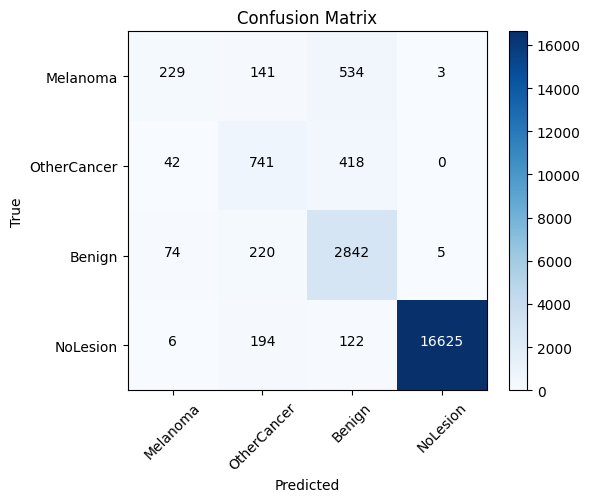


Sensitivity & Specificity:
Melanoma      Sensitivity: 0.252  Specificity: 0.994
OtherCancer   Sensitivity: 0.617  Specificity: 0.974
Benign        Sensitivity: 0.905  Specificity: 0.944
NoLesion      Sensitivity: 0.981  Specificity: 0.998

AUC per class:
Melanoma      AUC = 0.957
OtherCancer   AUC = 0.974
Benign        AUC = 0.982
NoLesion      AUC = 0.997


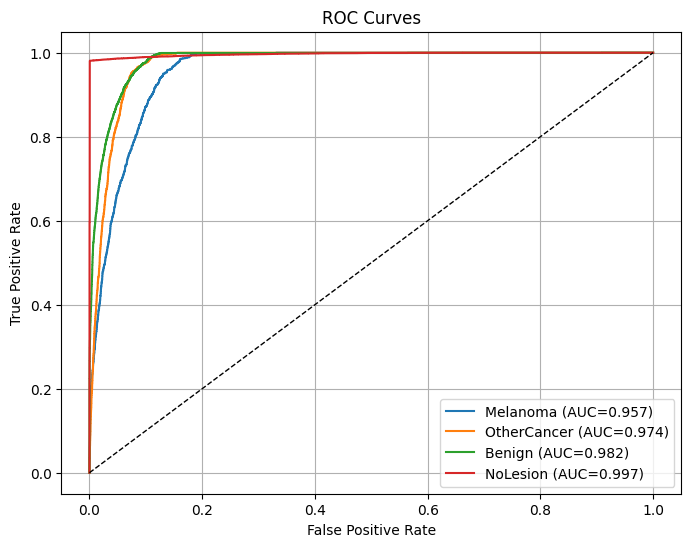

In [75]:
# %% Cell new Final Test Evaluation with AUC, Sensitivity & Specificity


# 1) Load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_name = "fusion_finetuned_best.pth"  # or "fusion_scratch_best.pth"
best_path = os.path.join(model_weights_dir, best_name)
print("Loading checkpoint:", best_path)
ckpt = torch.load(best_path, map_location=device)

# 2) Build & load model
model = FusionModel(pretrained=("finetuned" in best_name), backbone_ckpt_path=None).to(device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

# 3) Inference: collect labels, preds, probs
all_trues, all_preds, all_probs = [], [], []
with torch.no_grad():
    for imgs, metas, lbls in test_loader:
        imgs, metas = imgs.to(device), metas.to(device)
        logits = model(imgs, metas)["logits"]
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = logits.argmax(1).cpu().tolist()
        all_trues.extend(lbls.tolist())
        all_preds.extend(preds)
        all_probs.extend(probs)

classes = ["Melanoma", "OtherCancer", "Benign", "NoLesion"]

# 4) Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(all_trues, all_preds, target_names=classes))

cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)
thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i,j]}", ha="center",
             color="white" if cm[i,j] > thresh else "black")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# 5) Sensitivity & Specificity
print("\nSensitivity & Specificity:")
total = cm.sum()
for i, cls in enumerate(classes):
    TP = cm[i,i]
    FN = cm[i,:].sum() - TP
    FP = cm[:,i].sum() - TP
    TN = total - (TP + FN + FP)
    sens = TP/(TP+FN) if (TP+FN)>0 else 0.0
    spec = TN/(TN+FP) if (TN+FP)>0 else 0.0
    print(f"{cls:12s}  Sensitivity: {sens:.3f}  Specificity: {spec:.3f}")

# 6) AUC per class & ROC curves
y_true = np.array(all_trues)
y_prob = np.array(all_probs)

print("\nAUC per class:")
for i, cls in enumerate(classes):
    y_bin   = (y_true==i).astype(int)
    auc_sc  = roc_auc_score(y_bin, y_prob[:,i])
    print(f"{cls:12s}  AUC = {auc_sc:.3f}")

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



=== Evaluating fusion_scratch ===
Loading checkpoint: C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\fusion_scratch_best.pth

Classification Report:
              precision    recall  f1-score   support

    Melanoma       0.55      0.38      0.45       907
 OtherCancer       0.55      0.75      0.63      1201
      Benign       0.79      0.83      0.81      3141
    NoLesion       1.00      0.98      0.99     16947

    accuracy                           0.92     22196
   macro avg       0.72      0.74      0.72     22196
weighted avg       0.93      0.92      0.92     22196



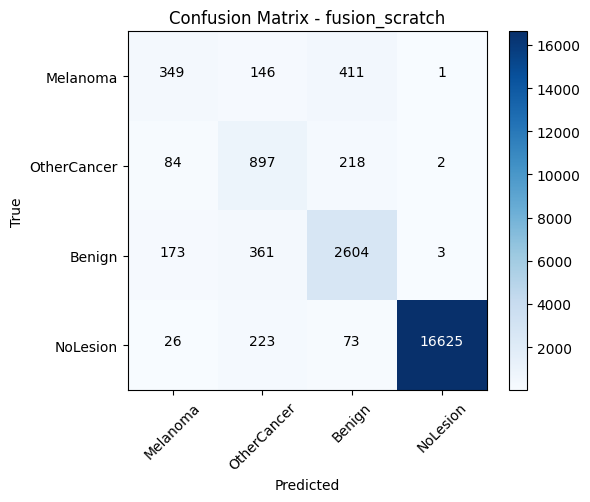


Sensitivity & Specificity:
Melanoma      Sensitivity: 0.385  Specificity: 0.987
OtherCancer   Sensitivity: 0.747  Specificity: 0.965
Benign        Sensitivity: 0.829  Specificity: 0.963
NoLesion      Sensitivity: 0.981  Specificity: 0.999

AUC per class:
Melanoma      AUC = 0.958
OtherCancer   AUC = 0.976
Benign        AUC = 0.983
NoLesion      AUC = 0.997


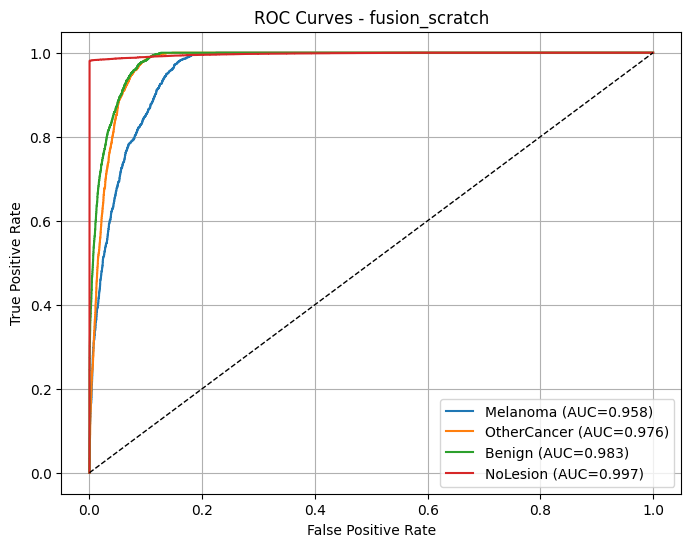


=== Evaluating fusion_finetuned ===
Loading checkpoint: C:\Users\kagan\Dropbox\קורס DS בר-אילן\שיעורים\Projects\Final Project\Skin Cancer Detection\Src\Model_Weights\fusion_finetuned_best.pth

Classification Report:
              precision    recall  f1-score   support

    Melanoma       0.65      0.25      0.36       907
 OtherCancer       0.57      0.62      0.59      1201
      Benign       0.73      0.90      0.81      3141
    NoLesion       1.00      0.98      0.99     16947

    accuracy                           0.92     22196
   macro avg       0.74      0.69      0.69     22196
weighted avg       0.92      0.92      0.92     22196



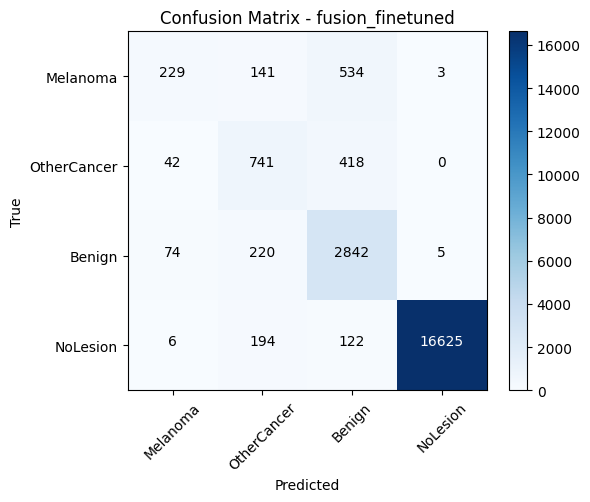


Sensitivity & Specificity:
Melanoma      Sensitivity: 0.252  Specificity: 0.994
OtherCancer   Sensitivity: 0.617  Specificity: 0.974
Benign        Sensitivity: 0.905  Specificity: 0.944
NoLesion      Sensitivity: 0.981  Specificity: 0.998

AUC per class:
Melanoma      AUC = 0.957
OtherCancer   AUC = 0.974
Benign        AUC = 0.982
NoLesion      AUC = 0.997


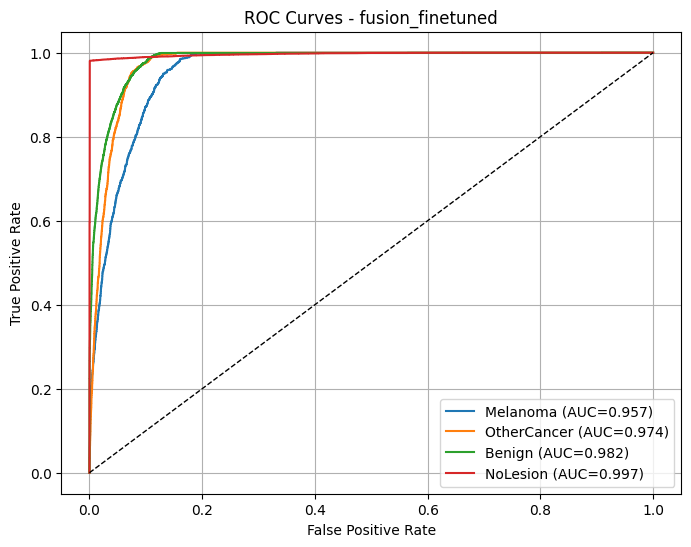


=== Model Comparison ===
Mean AUC Scores:
Scratch:   0.979
Finetuned: 0.977

Overall Accuracy:
Scratch:   92.25%
Finetuned: 92.08%


In [76]:
def evaluate_model(model_name, device, model_weights_dir, test_loader, classes):
    """Evaluate a saved model and return metrics"""
    print(f"\n=== Evaluating {model_name} ===")
    
    # 1) Load checkpoint
    best_path = os.path.join(model_weights_dir, f"{model_name}_best.pth")
    print("Loading checkpoint:", best_path)
    ckpt = torch.load(best_path, map_location=device)

    # 2) Build & load model
    model = FusionModel(
        pretrained=("finetuned" in model_name),
        backbone_ckpt_path=None
    ).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    # 3) Inference
    all_trues, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for imgs, metas, lbls in test_loader:
            imgs, metas = imgs.to(device), metas.to(device)
            logits = model(imgs, metas)["logits"]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = logits.argmax(1).cpu().tolist()
            all_trues.extend(lbls.tolist())
            all_preds.extend(preds)
            all_probs.extend(probs)

    # 4) Classification report
    print("\nClassification Report:")
    print(classification_report(all_trues, all_preds, target_names=classes))

    # 5) Confusion Matrix
    cm = confusion_matrix(all_trues, all_preds)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}", ha="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # 6) Sensitivity & Specificity
    print("\nSensitivity & Specificity:")
    total = cm.sum()
    for i, cls in enumerate(classes):
        TP = cm[i,i]
        FN = cm[i,:].sum() - TP
        FP = cm[:,i].sum() - TP
        TN = total - (TP + FN + FP)
        sens = TP/(TP+FN) if (TP+FN)>0 else 0.0
        spec = TN/(TN+FP) if (TN+FP)>0 else 0.0
        print(f"{cls:12s}  Sensitivity: {sens:.3f}  Specificity: {spec:.3f}")

    # 7) AUC & ROC curves
    y_true = np.array(all_trues)
    y_prob = np.array(all_probs)

    print("\nAUC per class:")
    aucs = []
    for i, cls in enumerate(classes):
        y_bin = (y_true==i).astype(int)
        auc_sc = roc_auc_score(y_bin, y_prob[:,i])
        aucs.append(auc_sc)
        print(f"{cls:12s}  AUC = {auc_sc:.3f}")

    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve((y_true==i).astype(int), y_prob[:,i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'aucs': aucs,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_trues
    }

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ["Melanoma", "OtherCancer", "Benign", "NoLesion"]

# Evaluate both models
scratch_results = evaluate_model(
    model_name="fusion_scratch",
    device=device,
    model_weights_dir=model_weights_dir,
    test_loader=test_loader,
    classes=classes
)

finetuned_results = evaluate_model(
    model_name="fusion_finetuned", 
    device=device,
    model_weights_dir=model_weights_dir,
    test_loader=test_loader,
    classes=classes
)

# Print comparative summary
print("\n=== Model Comparison ===")
print("Mean AUC Scores:")
print(f"Scratch:   {np.mean(scratch_results['aucs']):.3f}")
print(f"Finetuned: {np.mean(finetuned_results['aucs']):.3f}")

# Optional: Calculate accuracy for both
scratch_acc = accuracy_score(scratch_results['true_labels'], scratch_results['predictions'])
finetuned_acc = accuracy_score(finetuned_results['true_labels'], finetuned_results['predictions'])
print("\nOverall Accuracy:")
print(f"Scratch:   {scratch_acc*100:.2f}%")
print(f"Finetuned: {finetuned_acc*100:.2f}%")